<h1><font color='#306998'><center>Extreme Gradient Boosting</center></font></h1>

---

## Implementation
We will use XGBClassifier from XGBoost library to predict future prices of the security by creating a custom list of features from the raw price series. 

**Import Libraries**

In [3]:
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter(action='ignore', category=FutureWarning)

# Data manipulation 
import pandas as pd
import numpy as np

# Quant library
from quantmod.timeseries import *
from quantmod.indicators import *

# Plotting
import matplotlib.pyplot as plt

# Preprocessing
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.model_selection import (train_test_split, 
                                    RandomizedSearchCV, 
                                    TimeSeriesSplit, 
                                    )
# Classifier
import xgboost as xgb
from xgboost import XGBClassifier, plot_importance, to_graphviz

# metrics
from sklearn.metrics import (accuracy_score,
                             auc,
                             roc_curve, 
                             RocCurveDisplay,
                             ConfusionMatrixDisplay,
                             confusion_matrix
                            )


from sklearn.metrics import (classification_report, 
                             confusion_matrix 
                            )

### Retrieve Data
We will retrieve the adjusted closed price of SPY from locally stored data.

In [4]:
# Load file
df = pd.read_csv('https://raw.githubusercontent.com/kannansingaravelu/datasets/main/spy.csv', index_col=0, parse_dates=True, dayfirst=True)

# Calculate returns
df['Returns'] = dailyReturn(df['Adj Close'])

# Verify the output
df

,Open,High,Low,Close,Adj Close,Volume,Returns
Date,,,,,,,
1999-12-31,146.843750,147.500000,146.250000,146.875000,100.376900,3172700,NaN
2000-01-03,148.250000,148.250000,143.875000,145.437500,99.394493,8164300,-0.009835
2000-01-04,143.531250,144.062500,139.640625,139.750000,95.507530,8089800,-0.039892
2000-01-05,139.937500,141.531250,137.250000,140.000000,95.678391,12177900,0.001787
2000-01-06,139.625000,141.500000,137.750000,137.750000,94.140717,6227200,-0.016202
...,...,...,...,...,...,...,...
2020-04-23,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,-0.000072
2020-04-24,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,0.013842
2020-04-27,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,0.014315


### EDA of Original dataset

In [5]:
# Descriptive statistics
df.describe().T

,count,mean,std,min,25%,50%,75%,max
Open,5114.0,1.598580e+02,6.067946e+01,6.795000e+01,1.157525e+02,1.370850e+02,2.017675e+02,3.377900e+02
High,5114.0,1.607984e+02,6.083027e+01,7.000000e+01,1.166625e+02,1.379550e+02,2.027875e+02,3.390800e+02
Low,5114.0,1.588300e+02,6.051593e+01,6.710000e+01,1.149025e+02,1.361100e+02,2.007225e+02,3.374800e+02
Close,5114.0,1.598609e+02,6.069407e+01,6.811000e+01,1.158975e+02,1.369450e+02,2.018725e+02,3.383400e+02
Adj Close,5114.0,1.363339e+02,6.792366e+01,5.418443e+01,8.741249e+01,1.064888e+02,1.829516e+02,3.363621e+02
Volume,5114.0,1.127593e+08,9.870486e+07,1.436600e+06,4.821255e+07,8.357545e+07,1.515544e+08,8.710263e+08
Returns,5113.0,2.096532e-04,1.255748e-02,-1.158865e-01,-4.648976e-03,6.417692e-04,5.800776e-03,1.355774e-01


### Cleaning & Imputation

Data is already cleaned. However, NaN values from derived features should be treated. 

In [6]:
# Check for missing values
df.isnull().sum()

Open         0
High         0
Low          0
Close        0
Adj Close    0
Volume       0
Returns      1
dtype: int64

### Feature Specification
Features or Predictors are also known as an independent variable which are used to determine the value of the target variable. We will use raw price to derive list of custom features.

In [7]:
# use quantmod to use indicators
features_list = []
for r in range(5, 50 , 5):
    df['SMA_'+str(r)] = SMA(df['Adj Close'], r)
    df['EMA_'+str(r)] = EMA(df['Adj Close'], r)
    features_list.append('SMA_'+str(r))
    features_list.append('EMA_'+str(r))

df['ATR'] = ATR(df)
df['BBANDS_L'] = BBands(df['Adj Close'],5,2)[0]
df['BBANDS_M'] = BBands(df['Adj Close'],5,2)[1]
df['BBANDS_U'] = BBands(df['Adj Close'],5,2)[2]
df['RSI'] = RSI(df['Adj Close'], 14)
df['MACD'] = MACD(df['Adj Close'], 5, 12, 26)[0]

# Drop NaN values
df.dropna(inplace=True)
df

,Open,High,Low,Close,Adj Close,Volume,Returns,SMA_5,EMA_5,SMA_10,...,SMA_40,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-06,140.812500,141.343750,138.750000,139.750000,95.507530,11967100,-0.009791,95.033429,95.007774,93.633495,...,96.217661,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398
2000-03-07,140.000000,140.156250,135.218750,137.046875,93.660210,20062000,-0.019532,94.980046,94.558586,93.775521,...,96.068965,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623
2000-03-08,136.468750,137.843750,135.031250,136.875000,93.542732,11808500,-0.001255,94.766475,94.219968,93.796876,...,95.908789,95.638417,96.027467,95.874238,3.037946,92.295848,94.766475,97.237102,44.917778,-0.647050
2000-03-09,137.250000,140.875000,136.125000,140.875000,96.276367,5500900,0.028805,95.086819,94.905434,94.279536,...,95.846855,95.669537,96.044552,95.891722,3.218750,92.282852,95.086819,97.890787,55.361687,-0.437612
2000-03-10,140.187500,142.000000,139.531250,140.125000,95.763870,7924600,-0.005337,94.950142,95.191580,94.744048,...,95.796668,95.674138,96.046452,95.886163,3.091518,92.424981,94.950142,97.475303,60.953175,-0.309419
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-04-23,280.489990,283.940002,278.750000,279.079987,279.079987,104709700,-0.000072,279.890002,278.672024,279.396005,...,268.434096,276.323438,274.331356,277.899923,8.602143,270.058661,279.890002,289.721344,67.266486,2.598033
2020-04-24,280.730011,283.700012,278.500000,282.970001,282.970001,85166000,0.013842,279.156000,280.104683,279.873004,...,268.114076,276.647660,273.175573,278.120361,8.395001,271.547767,279.156000,286.764233,71.968147,3.009828
2020-04-27,285.119995,288.269989,284.619995,287.049988,287.049988,77896600,0.014315,280.247998,282.419785,281.012003,...,267.927123,277.155091,272.187117,278.508606,7.428571,269.840615,280.247998,290.655381,66.666651,3.623628


In [8]:
# Convert to NumPy
X = df.drop(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Returns'],axis=1)
X.head(2)

,Volume,SMA_5,EMA_5,SMA_10,EMA_10,SMA_15,EMA_15,SMA_20,EMA_20,SMA_25,...,SMA_40,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-06,11967100,95.033429,95.007774,93.633495,94.527836,94.004034,94.574757,94.703468,94.791962,95.099208,...,96.217661,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398
2000-03-07,20062000,94.980046,94.558586,93.775521,94.370086,93.892270,94.460438,94.521402,94.684176,95.030441,...,96.068965,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623


### Target or Label Definition

Label or the target variable is also known as the dependent variable. Here, the target variable is whether the underlying price will close up or down on the next trading day. If the tomorrow’s closing price is greater than 99.50% of today’s closing price, then we will buy the underlying, else do nothing. 

In [9]:
# Define Target
df['Target'] = np.where(lead(df['Adj Close'])>0.995 * df['Adj Close'],1,0)  
df.head(2)

,Open,High,Low,Close,Adj Close,Volume,Returns,SMA_5,EMA_5,SMA_10,...,EMA_40,SMA_45,EMA_45,ATR,BBANDS_L,BBANDS_M,BBANDS_U,RSI,MACD,Target
Date,,,,,,,,,,,,,,,,,,,,,
2000-03-06,140.8125,141.34375,138.75000,139.750000,95.50753,11967100,-0.009791,95.033429,95.007774,93.633495,...,95.852846,96.306766,96.085670,2.891741,93.095617,95.033429,96.971241,50.576360,-0.603398,0
2000-03-07,140.0000,140.15625,135.21875,137.046875,93.66021,20062000,-0.019532,94.980046,94.558586,93.775521,...,95.745888,96.157506,95.980215,3.000000,92.881788,94.980046,97.078304,41.164487,-0.626623,1


In [10]:
df['Target'].sum()

np.int64(3858)

In [11]:
# Define label or target 
y = df['Target']
y

Date
2000-03-06    0
2000-03-07    1
2000-03-08    1
2000-03-09    0
2000-03-10    0
             ..
2020-04-23    1
2020-04-24    1
2020-04-27    1
2020-04-28    1
2020-04-29    0
Name: Target, Length: 5070, dtype: int64

**Split Data**

In [12]:
# Splitting the datasets into training and testing data.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

# Output the train and test data size
print(f"Train and Test Size {len(X_train)}, {len(X_test)}")

Train and Test Size 4056, 1014


**Feature Scaling**

In [13]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

**Class Weights**

In [14]:
# class weight function
def cwts(dfs):
    c0, c1 = np.bincount(dfs)
    w0=(1/c0)*(len(df))/2 
    w1=(1/c1)*(len(df))/2 
    return {0: w0, 1: w1}

**DMatrix**

In [15]:
# Use DMatrix from XGBoost
train_weights = [cwts(y_train)[0] if label == 0 else cwts(y_train)[1] for label in y_train]
dtrain = xgb.DMatrix(X_train_scaled, label=y_train, nthread=4, weight=train_weights, feature_names=X_train.columns.to_list())

test_weights = [cwts(y_test)[0] if label == 0 else cwts(y_test)[1] for label in y_test]
dtest = xgb.DMatrix(X_test_scaled, label=y_test, nthread=4, weight=test_weights, feature_names=X_test.columns.to_list())

## Base Model

We will now create and train the XGBoost (Regessor). All the feature and label should have a similar scale and the scaling can be accomplished by using the `StandardScaler` transformer.

### Fit Model

In [16]:
# specify params
params = {
    'objective': 'binary:logistic',
    'eval_metric': 'logloss',
    'max_depth': 3,
    'eta': 0.1,
    'subsample': 0.8,
    'colsample_bytree': 0.8
}

# train the model
base_model = xgb.train(
    params, 
    dtrain, 
    num_boost_round=100,
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    # early_stopping_rounds=20,
    # verbose_eval=20
    )

[0]	train-logloss:0.68700	eval-logloss:0.68874
[1]	train-logloss:0.68213	eval-logloss:0.68569
[2]	train-logloss:0.67809	eval-logloss:0.68384
[3]	train-logloss:0.67466	eval-logloss:0.68351
[4]	train-logloss:0.67108	eval-logloss:0.68092
[5]	train-logloss:0.66911	eval-logloss:0.67966
[6]	train-logloss:0.66660	eval-logloss:0.68021
[7]	train-logloss:0.66389	eval-logloss:0.67909
[8]	train-logloss:0.66139	eval-logloss:0.67490
[9]	train-logloss:0.65962	eval-logloss:0.67559
[10]	train-logloss:0.65788	eval-logloss:0.67219
[11]	train-logloss:0.65621	eval-logloss:0.66939
[12]	train-logloss:0.65434	eval-logloss:0.66722
[13]	train-logloss:0.65314	eval-logloss:0.66477
[14]	train-logloss:0.65198	eval-logloss:0.66166
[15]	train-logloss:0.65091	eval-logloss:0.66838
[16]	train-logloss:0.64984	eval-logloss:0.66478
[17]	train-logloss:0.64899	eval-logloss:0.67479
[18]	train-logloss:0.64800	eval-logloss:0.67431
[19]	train-logloss:0.64713	eval-logloss:0.67687
[20]	train-logloss:0.64625	eval-logloss:0.69117
[2

### Predict Model

In [17]:
# get probabilities 
y_proba = base_model.predict(dtest)
# get predictions
y_pred = np.round(y_proba)

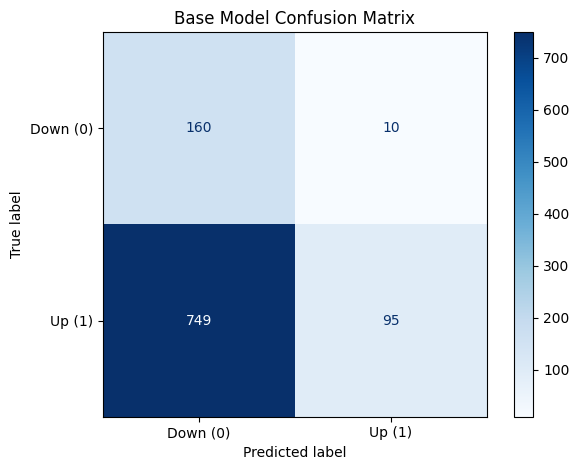

In [18]:
# Confusion Matrix - Base Model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Base Model Confusion Matrix')
plt.tight_layout()
plt.show()

In [19]:
# Classification report - Base Model
print(f"\n Base Model Classification Report:")
print(classification_report(y_test, y_pred))
    


 Base Model Classification Report:
              precision    recall  f1-score   support

           0       0.18      0.94      0.30       170
           1       0.90      0.11      0.20       844

    accuracy                           0.25      1014
   macro avg       0.54      0.53      0.25      1014
weighted avg       0.78      0.25      0.22      1014



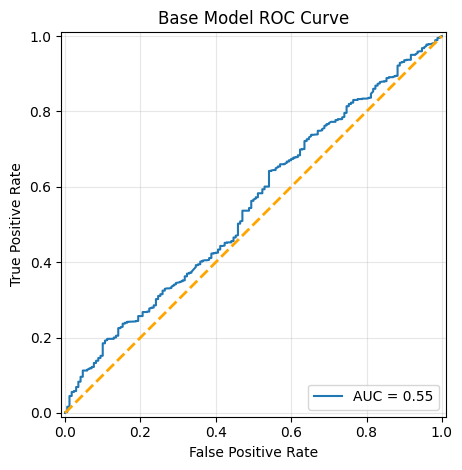

In [20]:
# ROC Curve - Base Model
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('Base Model ROC Curve')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [21]:
# Calculate training accuracy
train_preds = np.round(base_model.predict(dtrain))
train_accuracy = accuracy_score(y_train, train_preds)

# Calculate test accuracy
test_preds = np.round(base_model.predict(dtest))
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Training - Test): {train_accuracy - test_accuracy:.4f}")

Training Accuracy: 0.6958
Test Accuracy: 0.2515
Difference (Training - Test): 0.4443


## Hyperparameter Tuning

### RandomizedSearch
The RandomizedSearchCV implements a “fit” and a “score” method and perform randomized search on hyper parameters. The parameters of the estimator used to apply these methods are optimized by cross-validated search over parameter settings. In contrast to GridSearchCV, not all parameter values are tried out, but rather a fixed number of parameter settings is sampled from the specified distributions. 

In [22]:
# Create XGBoost classifier for sklearn API
xgb_classifier = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
)

In [23]:
# Cross-validation
tscv = TimeSeriesSplit(n_splits=5, gap=1)

In [24]:
# Hyperparameter grid
param_grid = {
    'max_depth': [3, 4, 5, 6, 7],
    'learning_rate': [0.01, 0.05, 0.1, 0.2],
    'n_estimators': [50, 100, 200, 300],
    'subsample': [0.6, 0.7, 0.8, 0.9],
    'colsample_bytree': [0.6, 0.7, 0.8, 0.9],
    'gamma': [0, 0.1, 0.2, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

In [25]:
# Initialize RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=xgb_classifier,
    param_distributions=param_grid,
    n_iter=100,
    scoring='roc_auc',
    cv=tscv,
    verbose=1,
    n_jobs=-1
)

In [26]:
# Fit RandomizedSearchCV
random_search.fit(X_train_scaled, y_train)

Fitting 5 folds for each of 100 candidates, totalling 500 fits


,estimator,"XGBClassifier...ree=None, ...)"
,param_distributions,"{'colsample_bytree': [0.6, 0.7, ...], 'gamma': [0, 0.1, ...], 'learning_rate': [0.01, 0.05, ...], 'max_depth': [3, 4, ...], ...}"
,n_iter,100
,scoring,'roc_auc'
,n_jobs,-1
,refit,True
,cv,TimeSeriesSpl...est_size=None)
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,None
,error_score,nan


In [27]:
# Print best parameters
print("\nBest parameters found by RandomizedSearchCV:")
print(random_search.best_params_)
print(f"Best score: {random_search.best_score_:.4f}")


Best parameters found by RandomizedSearchCV:
{'subsample': 0.8, 'n_estimators': 50, 'min_child_weight': 5, 'max_depth': 4, 'learning_rate': 0.01, 'gamma': 0.3, 'colsample_bytree': 0.7}
Best score: 0.5939


## Optimized Model
Let's now train and predict the model with the best search parameter

In [28]:
# Train optimized model with XGBoost using DMatrix
optimized_params = random_search.best_params_.copy()

# Convert parameters for xgb.train()
optimized_params['eta'] = optimized_params.pop('learning_rate')
optimized_params['objective'] = 'binary:logistic'
optimized_params['eval_metric'] = 'logloss'

print("\nTraining optimized XGBoost model with best parameters...")
optimized_model = xgb.train(
    optimized_params,
    dtrain,
    num_boost_round=optimized_params.pop('n_estimators'),
    evals=[(dtrain, 'train'), (dtest, 'eval')],
    # early_stopping_rounds=20,
    # verbose_eval=20
)


Training optimized XGBoost model with best parameters...
[0]	train-logloss:0.69254	eval-logloss:0.69285
[1]	train-logloss:0.69172	eval-logloss:0.69209
[2]	train-logloss:0.69104	eval-logloss:0.69172
[3]	train-logloss:0.69037	eval-logloss:0.69128
[4]	train-logloss:0.68973	eval-logloss:0.69105
[5]	train-logloss:0.68919	eval-logloss:0.69069
[6]	train-logloss:0.68861	eval-logloss:0.69096
[7]	train-logloss:0.68790	eval-logloss:0.69058
[8]	train-logloss:0.68730	eval-logloss:0.69041
[9]	train-logloss:0.68665	eval-logloss:0.69029
[10]	train-logloss:0.68598	eval-logloss:0.68959
[11]	train-logloss:0.68529	eval-logloss:0.68958
[12]	train-logloss:0.68460	eval-logloss:0.68919
[13]	train-logloss:0.68396	eval-logloss:0.68865
[14]	train-logloss:0.68336	eval-logloss:0.68791
[15]	train-logloss:0.68271	eval-logloss:0.68765
[16]	train-logloss:0.68213	eval-logloss:0.68712
[17]	train-logloss:0.68153	eval-logloss:0.68650
[18]	train-logloss:0.68098	eval-logloss:0.68625
[19]	train-logloss:0.68050	eval-logloss:

In [29]:
# Make predictions with basic model
y_proba = optimized_model.predict(dtest)
y_pred = np.round(y_proba)

In [30]:
y_proba[:5]

array([0.51270473, 0.4871268 , 0.49679017, 0.51386684, 0.50962424],
      dtype=float32)

In [31]:
y_proba.shape

(1014,)

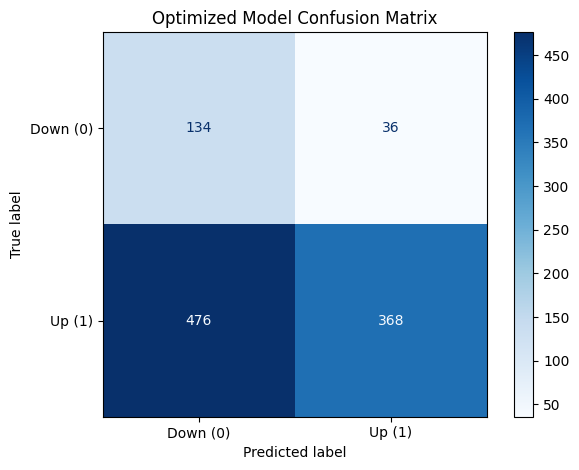

In [32]:
# Confusion Matrix - Base Model
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Down (0)', 'Up (1)'])
disp.plot(cmap='Blues')
plt.title('Optimized Model Confusion Matrix')
plt.tight_layout()
plt.show()

In [33]:
# Print classification report
print("\n Optimized Model Classification Report:")
print(classification_report(y_test, y_pred))


 Optimized Model Classification Report:
              precision    recall  f1-score   support

           0       0.22      0.79      0.34       170
           1       0.91      0.44      0.59       844

    accuracy                           0.50      1014
   macro avg       0.57      0.61      0.47      1014
weighted avg       0.80      0.50      0.55      1014



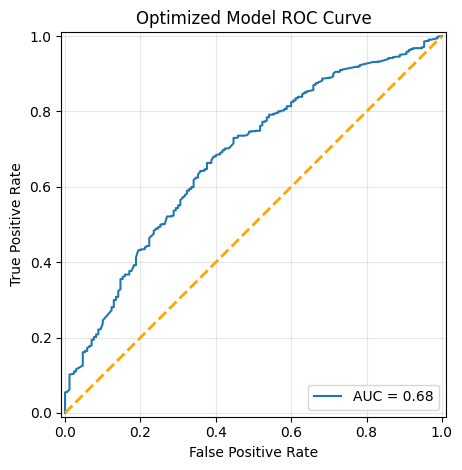

In [34]:
# ROC Curve - Optimized Model
fpr, tpr, _ = roc_curve(y_test, y_proba)
roc_auc = auc(fpr, tpr)

disp = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc)
disp.plot()

plt.title('Optimized Model ROC Curve')
plt.plot([0, 1], [0, 1], color='orange', lw=2, linestyle='--')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

In [35]:
# Calculate training accuracy
train_preds = np.round(optimized_model.predict(dtrain))
train_accuracy = accuracy_score(y_train, train_preds)

# Calculate test accuracy
test_preds = np.round(optimized_model.predict(dtest))
test_accuracy = accuracy_score(y_test, test_preds)

print(f"Training Accuracy: {train_accuracy:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Difference (Training - Test): {train_accuracy - test_accuracy:.4f}")

Training Accuracy: 0.6509
Test Accuracy: 0.4951
Difference (Training - Test): 0.1558


**OPTIONAL - EXAMPLE - Save Model**

In [36]:
# Save the optimized model - XGBoost's native format
optimized_model.save_model('ks_xgboost_model.json')
print("\nOptimized model saved as 'ks_xgboost_model.json'")


Optimized model saved as 'ks_xgboost_model.json'


**OPTIONAL - EXAMPLE - Load Model**

In [37]:
# OPTIONAL
# Example of loading the model
# loaded_model = xgb.Booster()
# loaded_model.load_model('ks_xgboost_model.json')
# predictions = loaded_model.predict(dtest)

### Feature Importance

Feature Importance refers to techniques that calculate a score for all the input features for a given model where the scores represent the “importance” of each feature. It is calculated as the decrease in node impurity weighted by the probability of reaching that node. The node probability can be calculated by the number of samples that reach the node, divided by the total number of samples. The higher the value the more important the feature. 

The Gain is the most relevant attribute to interpret the relative importance of each feature.

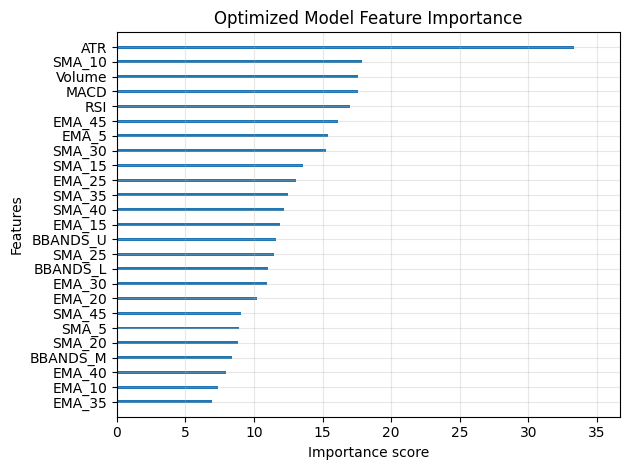

In [38]:
# Plot the feature importance of the optimized model
plot_importance(optimized_model, importance_type='gain', title='Optimized Model Feature Importance', show_values=False)
plt.tight_layout()
plt.grid(True, alpha=0.3)
plt.show()
